In [1]:
#Activation of the libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import time

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.0011749 (max: 1e-06)
	Norm deltaX: 0.00545578, Norm R: 0.43269
	deltaX: 0.00263936 -0.00477486 
	deltaR: 0.172082 -0.397 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 8.884e-06 (max: 1e-06)
	Norm deltaX: 0.000603034, Norm R: 0.0473264
	deltaX: -1.52751e-05 -0.00060284 
	deltaR: 0.0362774 -0.030393 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 7.10808e-08 (max: 1e-06)
	Norm deltaX: 4.26275e-05, Norm R: 0.00343462
	deltaX: 1.35091e-05 -4.04302e-05 
	deltaR: 0.00183587 -0.00290279 

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.0015419 (max: 1e-06)
	Norm deltaX: 0.00475039, Norm R: 0.751036
	deltaX: 0.00327571 -0.00344034 
	deltaR: 0.174126 -0.730571 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 3.48634e-05 (max: 1e-06)
	Norm deltaX: 0.000975367, Norm R: 0.151285
	deltaX: -8.52693e-05 -0.000971632 
	deltaR: 0.126569 -0.0828701 
CTestEnergyIncr::test() - iteration: 3 curren

[[ 0.00000000e+00  0.00000000e+00]
 [-3.30358143e-02  2.63749029e+01]
 [-5.99528118e-02  4.84226514e+01]
 [-7.96675537e-02  6.64053657e+01]
 [-9.14173243e-02  8.12945572e+01]
 [-9.47752592e-02  9.45873133e+01]
 [-8.96853888e-02  1.08050057e+02]
 [-7.62507002e-02  1.23483924e+02]
 [-5.49940074e-02  1.42244887e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1.65166828e+02]
 [-2.67271850e-02  1

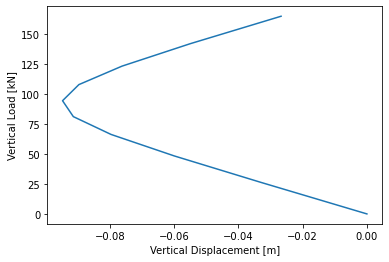

Running Time:  1.5588295459747314  seconds


In [2]:
# Define the model
ops.wipe()
start = time.time()
### model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)
ops.model('basic', '-ndm', 2, '-ndf', 2)


ArcLengthAlpha = 0.22 #Initial value of alpha (arc length parameter)
ArcLengthLambda = 0.12  #Initial value of lambda (arc length parameter)
spring_stiffness = 93.245


#Geometric and material properties
E1 = 100000  # Modulus of elasticity in kN/m^2
A1 = 0.01  # Area of the section in m^2
E2 = 600000  # Modulus of elasticity in kN/m^2
A2 = 0.01 # Area of the section in m^2

# Load parameters
Px = 0
Py = 30 #kN

#Coordinates of the nodes
Lhalf = 3.7
L = 2*Lhalf
### node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
ops.node(1, 0.0, 0.0)
ops.node(2, Lhalf, 1.0) 
ops.node(3, Lhalf, 1.0)
ops.node(4, L, 0.0)


# Define boundary conditions (first and third nodes are free restrained)
### fix(nodeTag, *constrValues)
ops.fix(1, 1, 1)
ops.fix(3, 1, 1)
ops.fix(4, 1, 1)

# Define material
### uniaxialMaterial(matType, matTag, *matArgs)
ops.uniaxialMaterial('Elastic', 1, E1)
ops.uniaxialMaterial('Elastic', 2, E2)

# Spring stiffness in kN/m
 
ops.uniaxialMaterial('Elastic', 3, spring_stiffness)

# Define elements using corotTruss element (accounts for geometric nonlinearity)
### element(eleType, eleTag, *eleNodes, *eleArgs)
ops.element('corotTruss', 1, 1, 2, A1, 1)
ops.element('corotTruss', 2, 2, 4, A2, 2)
ops.element('zeroLength', 3, 3, 2, '-mat', 3, '-dir', 2)

# Define load at the middle node
### timeSeries(tsType, tsTag, *tsArgs)
ops.timeSeries('Linear', 1)
### pattern(patternType, patternTag, *patternArgs)
ops.pattern('Plain', 1, 1)

#Load
###load(nodeTag, *loadValues)
ops.load(2, 0, -Py)

# create SOE - System Of Equation
### system(systemType, *systemArgs)
ops.system('ProfileSPD')

# create DOF number
### numberer(numbererType, *numbererArgs)
ops.numberer('RCM')

# create constraint handler
### constraints(constraintType, *constraintArgs)
ops.constraints('Plain')

# create integrator
Nsteps=50 #Number of increments

ops.integrator('ArcLength', ArcLengthAlpha, ArcLengthLambda) 

# create algorithm
### algorithm(algoType, *algoArgs)
ops.algorithm('ModifiedNewton', '-initial') #MODIFIED NEWTON-RAPHSON!

# create test
### test(testType, *testArgs)
ops.test('EnergyIncr', 1.0e-6, 30, 4)

# create analysis object
### analysis(analysisType)
ops.analysis("Static")

#PERFORM ANALYSIS
data = np.zeros((Nsteps+1,2)) 
for j in range(Nsteps):
    ### analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.analyze(1) 
    data[j+1,0] = ops.nodeDisp(2,1)    #abs(ops.nodeDisp(2,2)) 
    data[j+1,1] = ops.getLoadFactor(1)*Py 
print(data)
results = pd.DataFrame(data, columns=['Displacement','Force'])
results.to_excel('Results - Arclength Method - RIKS AND WAMPNER.xlsx')

plt.plot(data[:,0], data[:,1])
plt.xlabel('Vertical Displacement [m]')
#plt.ylim(-30, 100)
plt.ylabel('Vertical Load [kN]')
plt.show()

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')